In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
#plt.show 하지 않아도 그래프 출력

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load and check data

# 2.1 Load DATA

In [2]:
#load data

train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
IDtest = test['PassengerId']

## 2.2 Outlier detection (이상치 감지)


In [3]:
def detect_outliers(df,n,features):
    '''
    takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according 
    to the Tukey method
    
    tukey method로 이상치 제어
    1분위수와 2분위수를 계산하고 이를 바탕으로 이상치를 제어하는 함수
    '''
    outlier_indices = []
    
    #iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range(IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
    
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v > n)
        
    return multiple_outliers

# detect outliers from Age, SibSp, Parch and Fare
# 해당 열 값이 해당 열의 사분위 범위를 벗어나면 이상치, 2개 이상인 경우에만 리스트 추가
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
    

In [4]:
train.loc[Outliers_to_drop] 
#Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
#drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## 2.3 joining train and test set

In [6]:
# join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## 2.4 check for null and missing values

In [7]:
# fill empty and nans values with nan
dataset = dataset.fillna(np.nan)

# check for null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [8]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
### summarize data
# summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3.Feature analysis

## 3.1 Numerical values

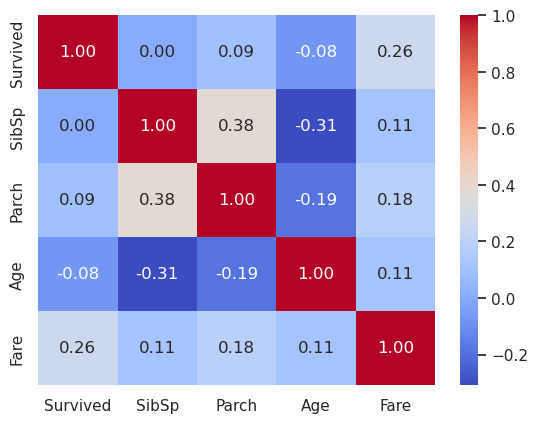

In [12]:
# Correlation matrix between numerical values(Sibsp Parch Age and Fare values) and Survived

g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, 
               fmt = '.2f', cmap = 'coolwarm')

## SibSP

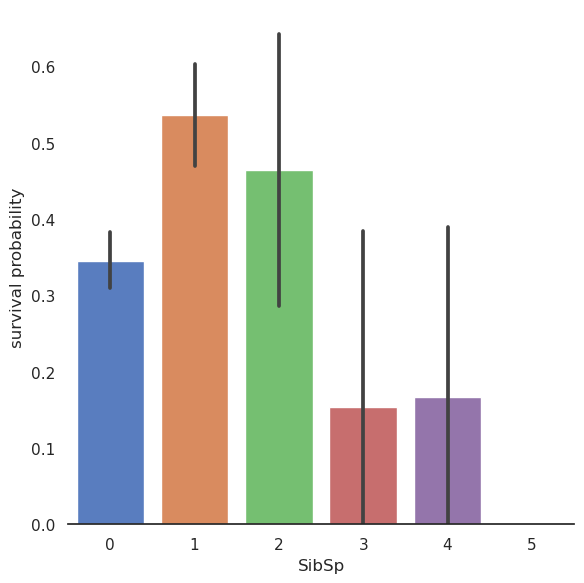

In [13]:
# explore SibSP feature vs survived
g = sns.catplot(x='SibSp', y='Survived', data=train, kind = 'bar', height=6, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

## parch

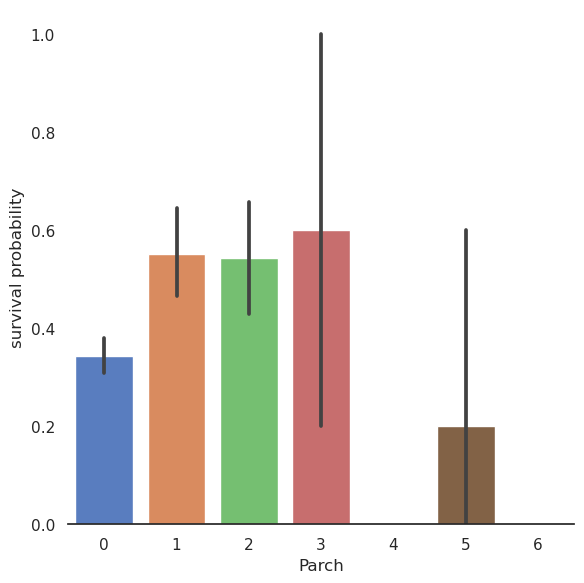

In [14]:
# explore parch feature vs survived
g = sns.catplot(x='Parch', y='Survived', data = train, kind = 'bar', height=6, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

## age

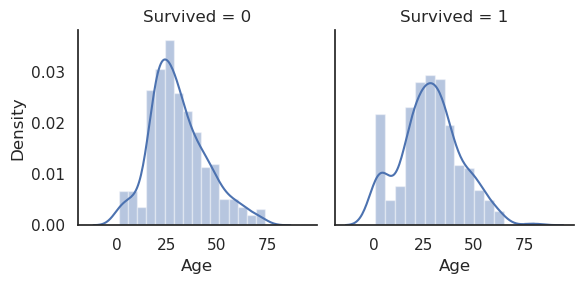

In [15]:
# explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

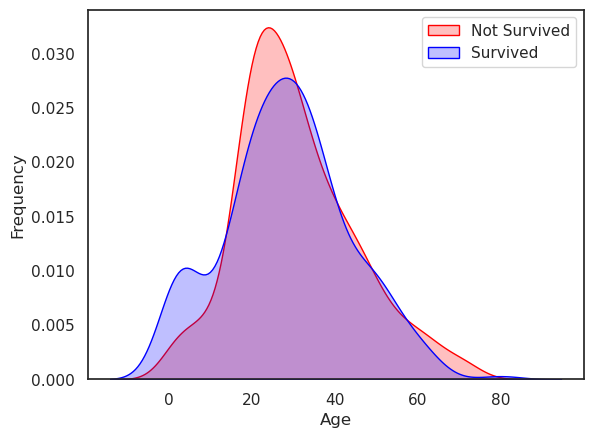

In [16]:
# explore Age distribution
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color ='Red', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], color = 'Blue', shade = True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

## fare

In [17]:
dataset['Fare'].isnull().sum()

1

In [18]:
# fill fare missing values with the median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

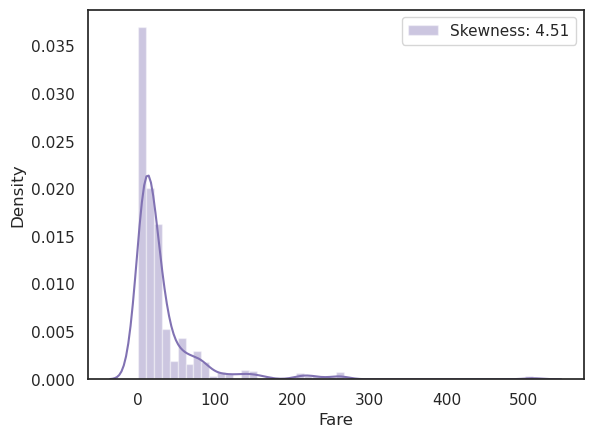

In [19]:
# Explore Fare distribution
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

In [20]:
# Apply log to Fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

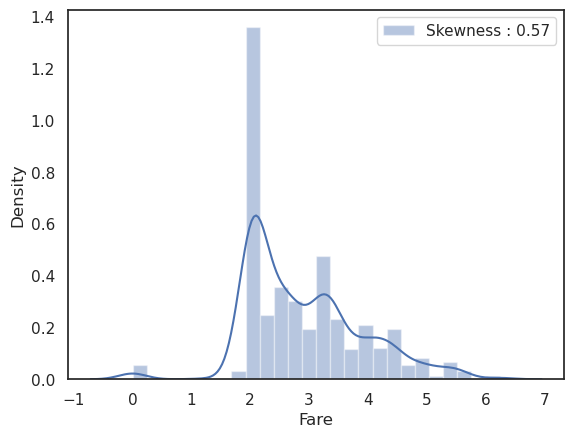

In [21]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

## 3.2 Categorical values

## Sex 

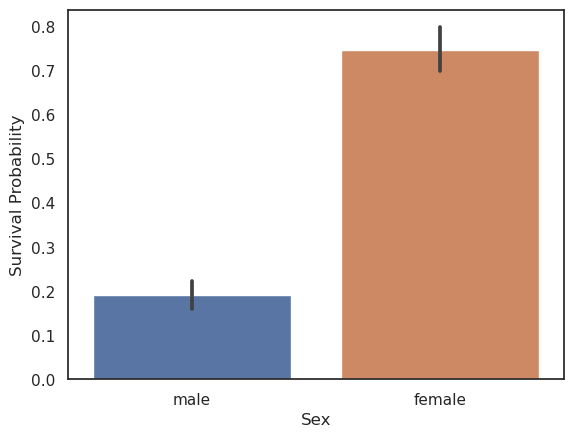

In [22]:
g = sns.barplot(x='Sex', y='Survived', data = train)
g = g.set_ylabel('Survival Probability')

In [23]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


## Pclass 

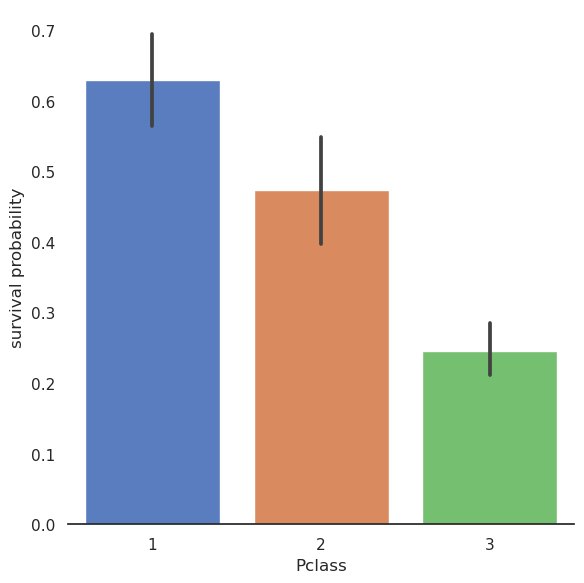

In [24]:
# Explore Pcalss vs Survived
g = sns.catplot(x='Pclass', y='Survived', data = train, kind='bar', height=6, palette ='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

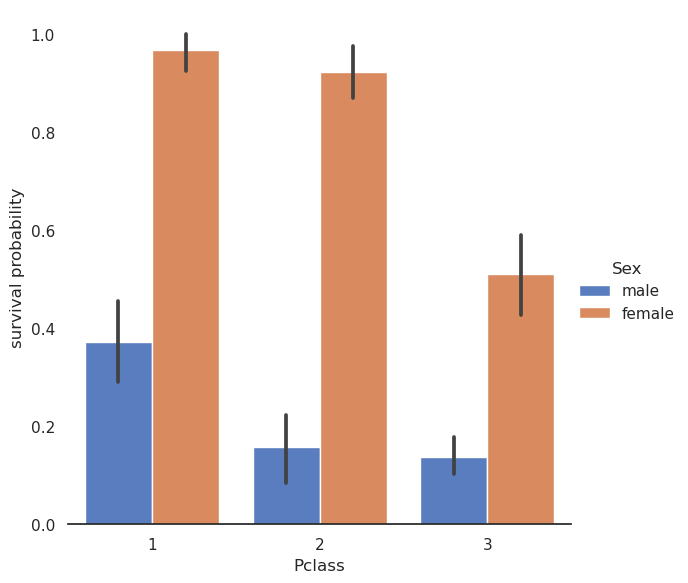

In [25]:
# explore Pclass VS survived by Sex
g = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, height=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

## Embarked 

In [26]:
dataset['Embarked'].isnull().sum()

2

In [27]:
#fill embarked nan values of dataset set with 's' most frequent value
dataset['Embarked'] = dataset['Embarked'].fillna('S')

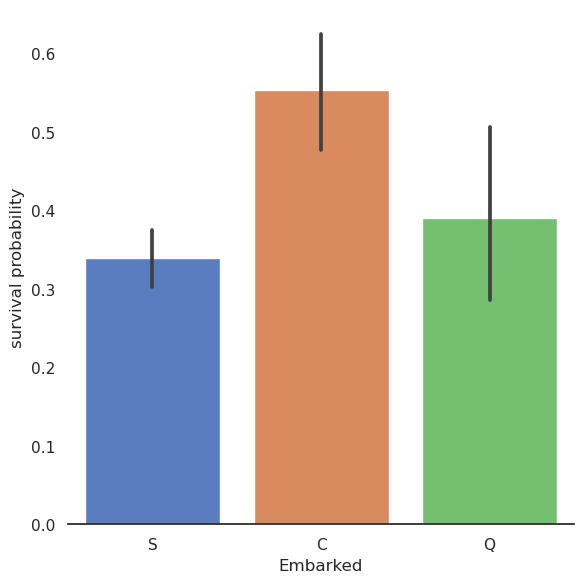

In [28]:
# explore Embarked vs Survived
g = sns.catplot(x='Embarked', y='Survived', data = train, height=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

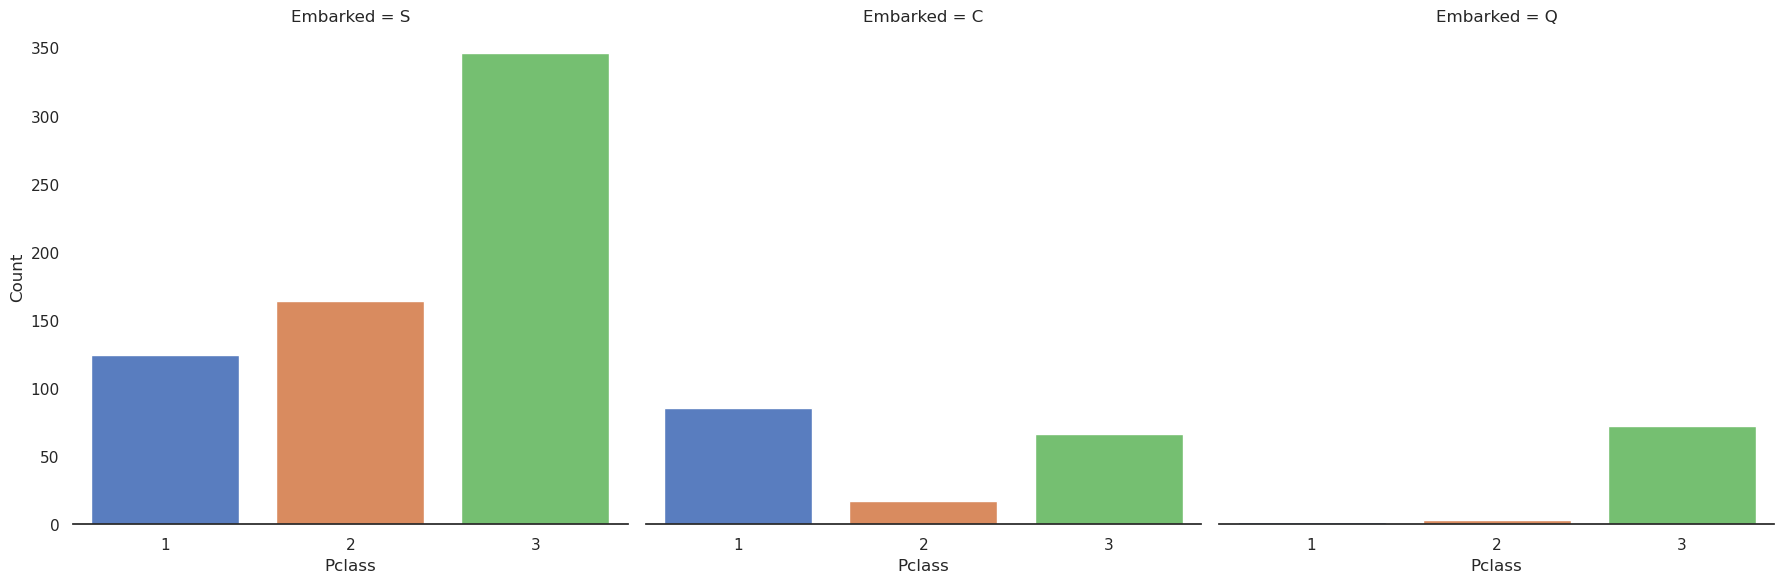

In [29]:

# Explore Pclass vs Embarked 
g = sns.catplot(x="Pclass", col="Embarked", data=train,
                height=6, kind="count", palette="muted")
g.despine(left=True)
g.set_ylabels("Count")

# Filling missing Values 

## 4.1 age 

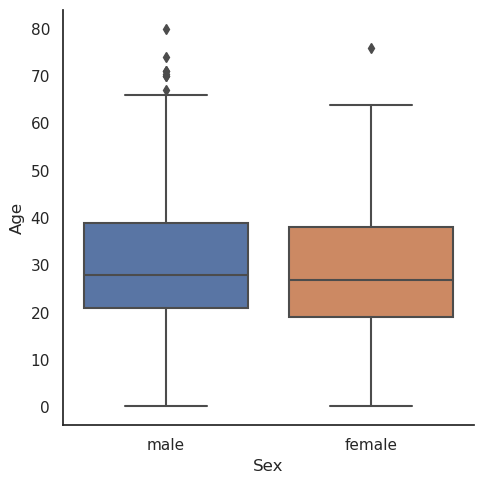

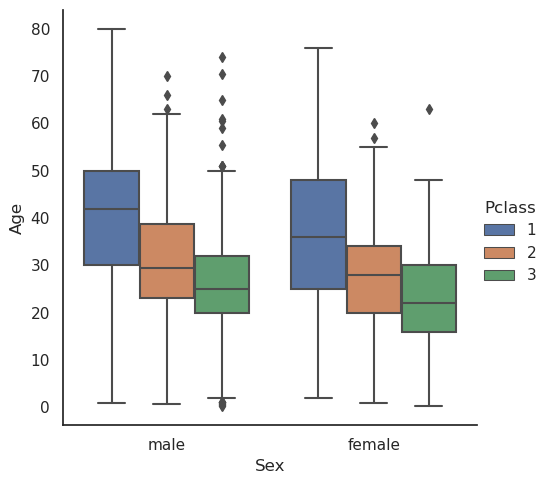

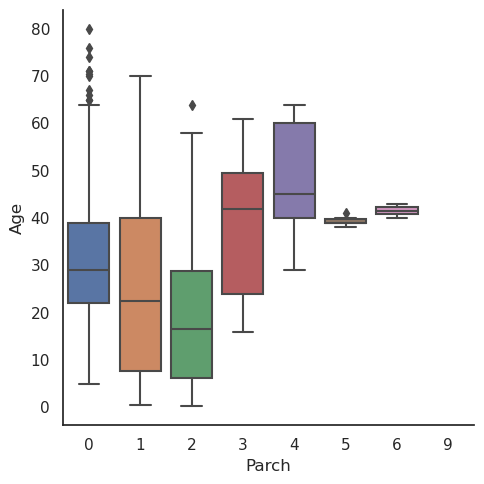

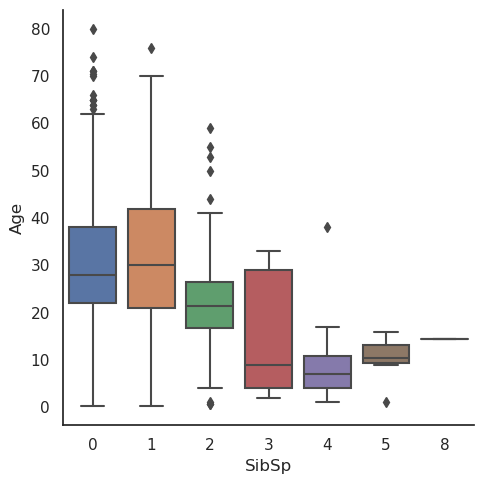

In [30]:
# explore Age vs Sex, Parch, Pclass and SibSP
g = sns.catplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.catplot(y='Age', x='SibSp', data=dataset, kind='box')

In [31]:
# conver Sex into categorical value 0 for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

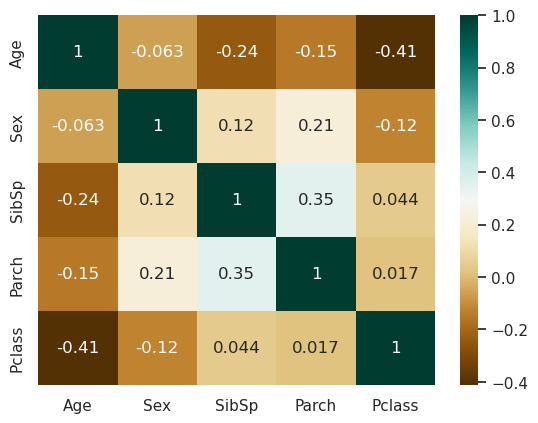

In [32]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

In [33]:
# filling missing value of age

## fill age with  median age of similar rows according to Pclass, Parch and SibSp
# index of nan age rows
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

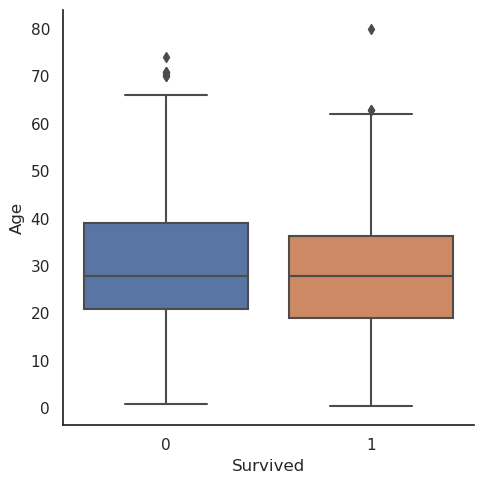

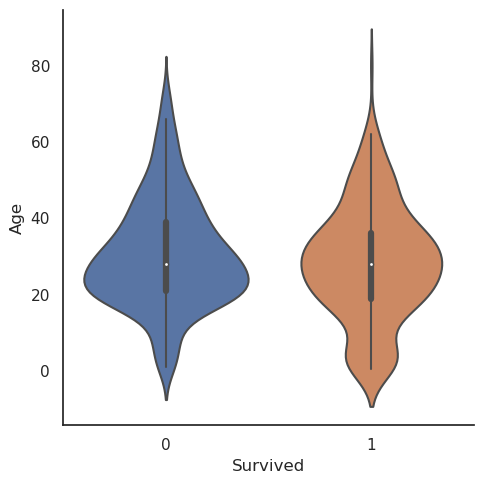

In [34]:
g = sns.catplot(x='Survived', y='Age', data=train, kind = 'box')
g = sns.catplot(x='Survived', y='Age', data=train, kind = 'violin')

# Featue enginerring

## name/title 

In [35]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [36]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

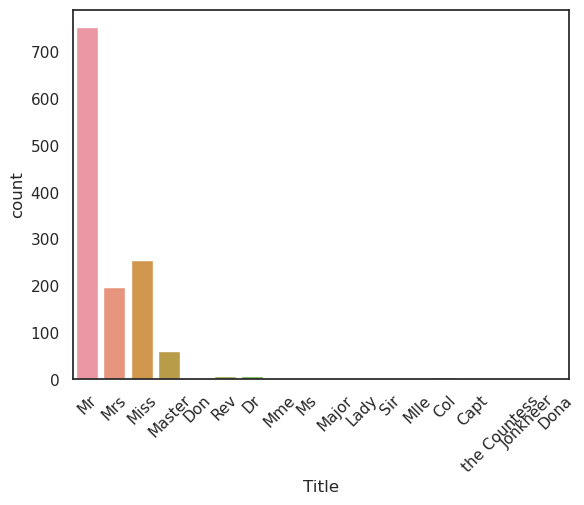

In [37]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [38]:
# Convert to categorical values Title 
# 필사진행하다가 오류로 안넘어가져서 결측치 -1로 채움
dataset["Title"] = dataset["Title"].fillna(-1)


dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

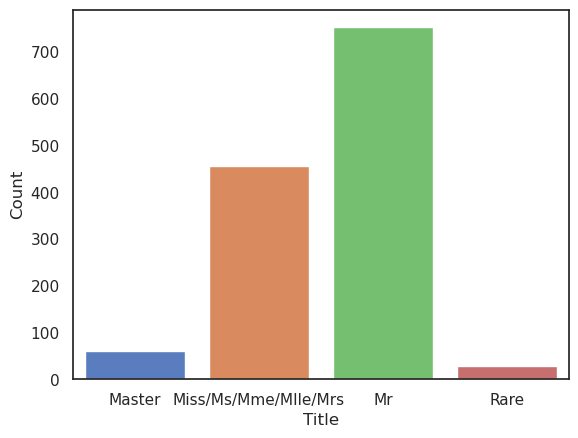

In [39]:
# Create a mapping for x-axis labels
title_labels = ["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"]

# Create the count plot
g = sns.countplot(data=dataset, x="Title", palette="muted")

# Set x-axis tick labels
g.set_xticklabels(title_labels)

# Set y-axis label
g.set_ylabel("Count")

# Show the plot
plt.show()

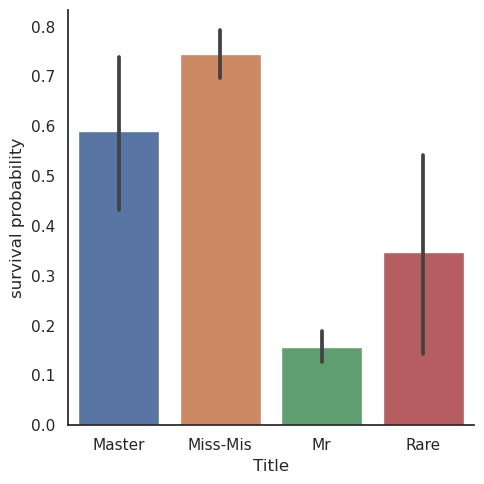

In [40]:
g = sns.catplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss-Mis', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

In [41]:
# drop name variable
dataset.drop(labels = ['Name'], axis = 1, inplace=True)

## family size 

In [42]:
# create a family size descriptor from SibSp and Parch
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

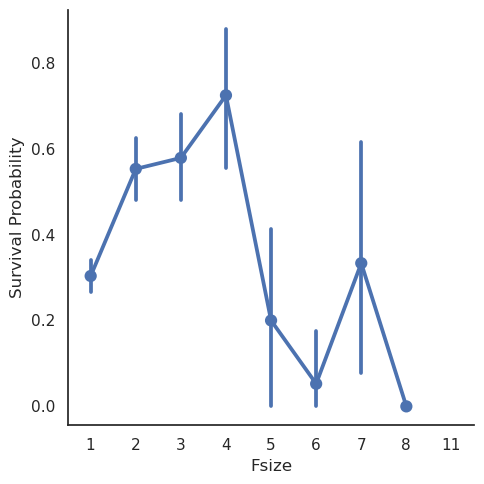

In [43]:
g = sns.catplot(x="Fsize",y="Survived",data = dataset, kind = 'point')
g = g.set_ylabels("Survival Probability")

In [44]:
# create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

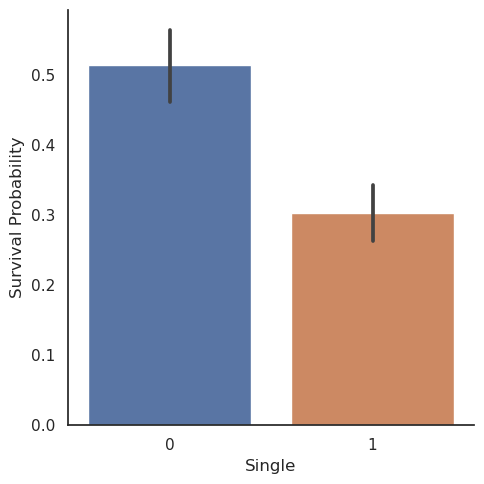

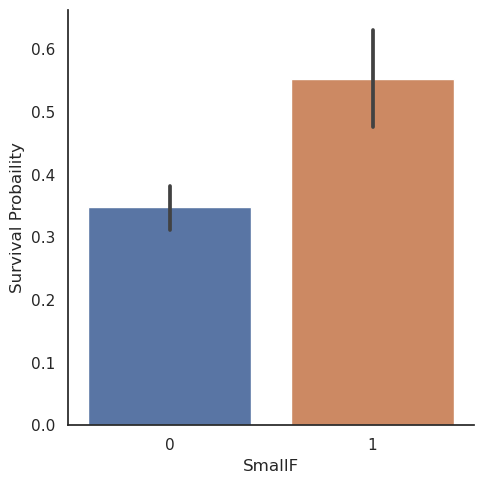

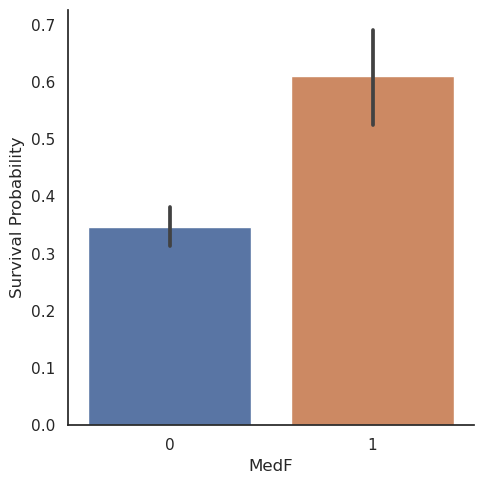

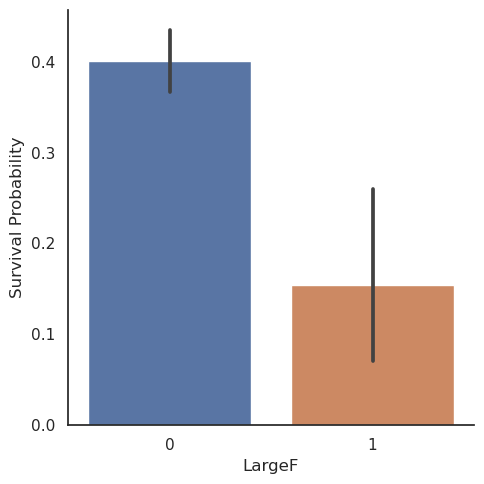

In [45]:
g = sns.catplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')
g = sns.catplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probaility')
g = sns.catplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')
g = sns.catplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

In [46]:
#convert to indicator values title and embarked
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix='Em')

In [47]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


## cabin 

In [48]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [49]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [50]:
dataset['Cabin'].isnull().sum()

1007

In [51]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [52]:
# replace the canin number by the type of cabin 'x' if not
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

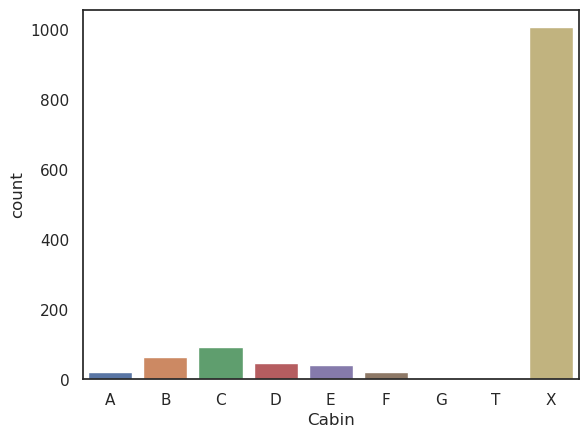

In [53]:
# Define the order for the 'Cabin' categories
cabin_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X']

# Create the count plot with specified order
g = sns.countplot(data=dataset, x='Cabin', order=cabin_order)

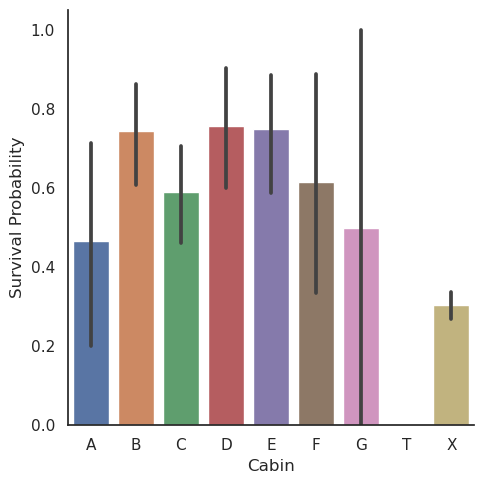

In [55]:
g = sns.catplot(y='Survived', x='Cabin', data=dataset, kind='bar',
               order = ['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels('Survival Probability')

In [56]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix='Cabin')

## 5.4 Ticket

In [57]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [59]:
## Treat Ticket by extrcting the ticket prefix. When there is no prefix it returns X.

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [60]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix='T')

In [62]:
# create categorical values for Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix='Pc')

In [63]:
#drop useless variables
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)

In [64]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## MODELING

In [65]:
## separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis = 1, inplace = True)

In [66]:
## separate train features and label

train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']

X_train = train.drop(labels = ['Survived'], axis = 1)

### 6.1 Simple modeling

#### cross validate models
I compared 10 popular classifiers and evaluate the mean accuract of each of them by a stratified kfold cross validation procedure.

- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceptron
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [67]:
# cross validate model with kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

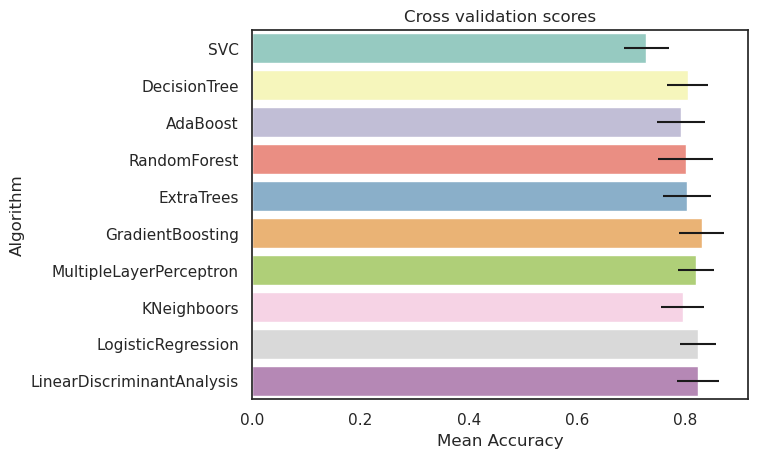

In [72]:
import warnings
warnings.filterwarnings('ignore')
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

I decided to choose the SVC,AdaBoost,RandomForest, ExtraTrees and the GradientBoosting classifiers for the ensemble modeling.

### 6.1.2 Hyperparameter tunning for best models

I performed a grid search optimization for Adaboost, ExtraTrees, RandomForest, GradientBoosting and SVC classifiers.

i set the n_jobs parameter to 4 since i hane 4 cpu, the computation time is clearly reduced

but be carefull, this steop can take a long time, i took me 15 min in total on 4cpu.

In [77]:
# 경고 무시 설정
warnings.filterwarnings("ignore", category=UserWarning)
#meta modeling with adaboost, rf, extratrees and gradientboostigng

# adaboost

DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {'base_estimator__criterion': ['gini', 'entropy'],
                 'base_estimator__splitter': ['best', 'random'],
                 'algorithm' : ['SAMㅉME','SAMME.R'],
                 'n_estimators' : [1,2],
                 'learning_rate': [0.0001,0.001,0.01,0.1,0.2,0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv=kfold, scoring='accuracy',
                       n_jobs =4, verbose = 1)

gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [78]:
gsadaDTC.best_score_

0.8275536261491316

In [79]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8354187946884576

In [80]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.836567926455567

In [81]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
 

0.8342696629213483

In [82]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

#### 6.1.3 Plot Learning Curves

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


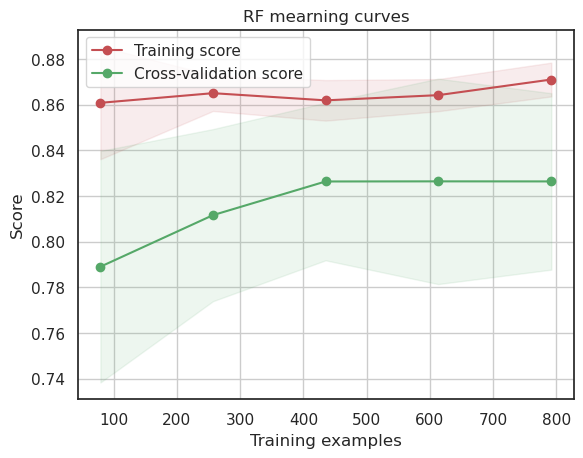

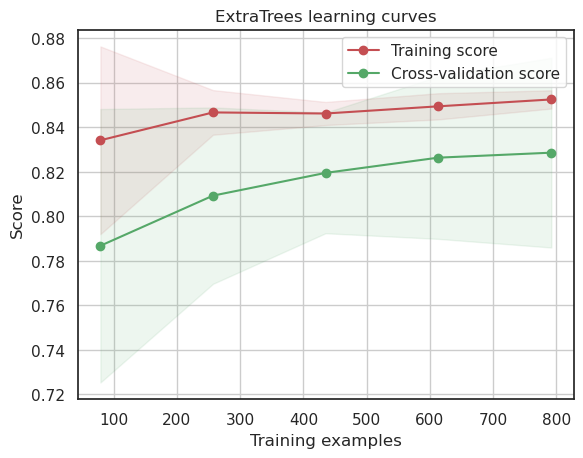

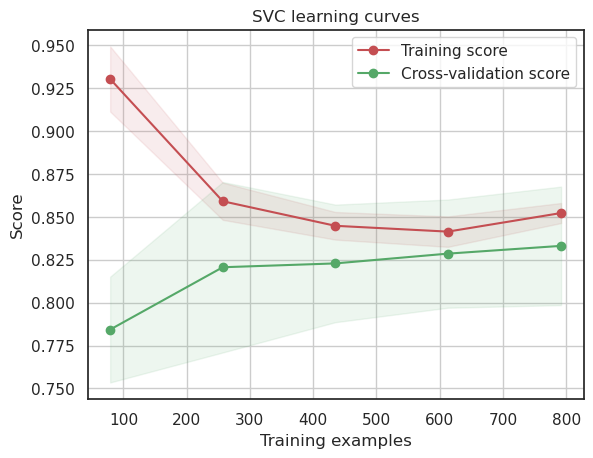

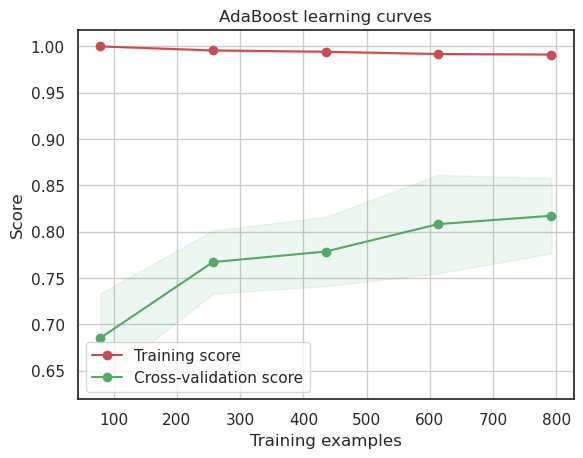

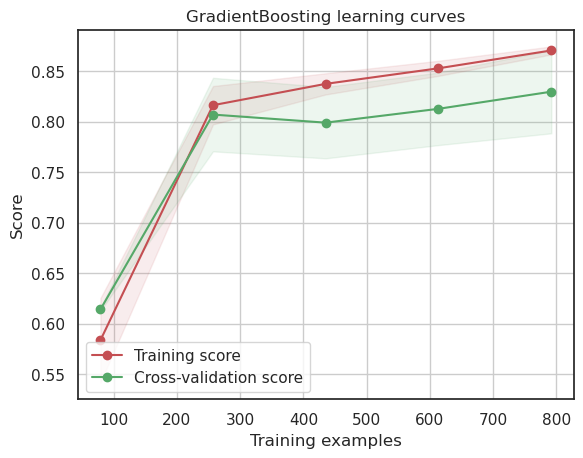

In [83]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

#### 6.1.4 feature importance of tree based classifiers 

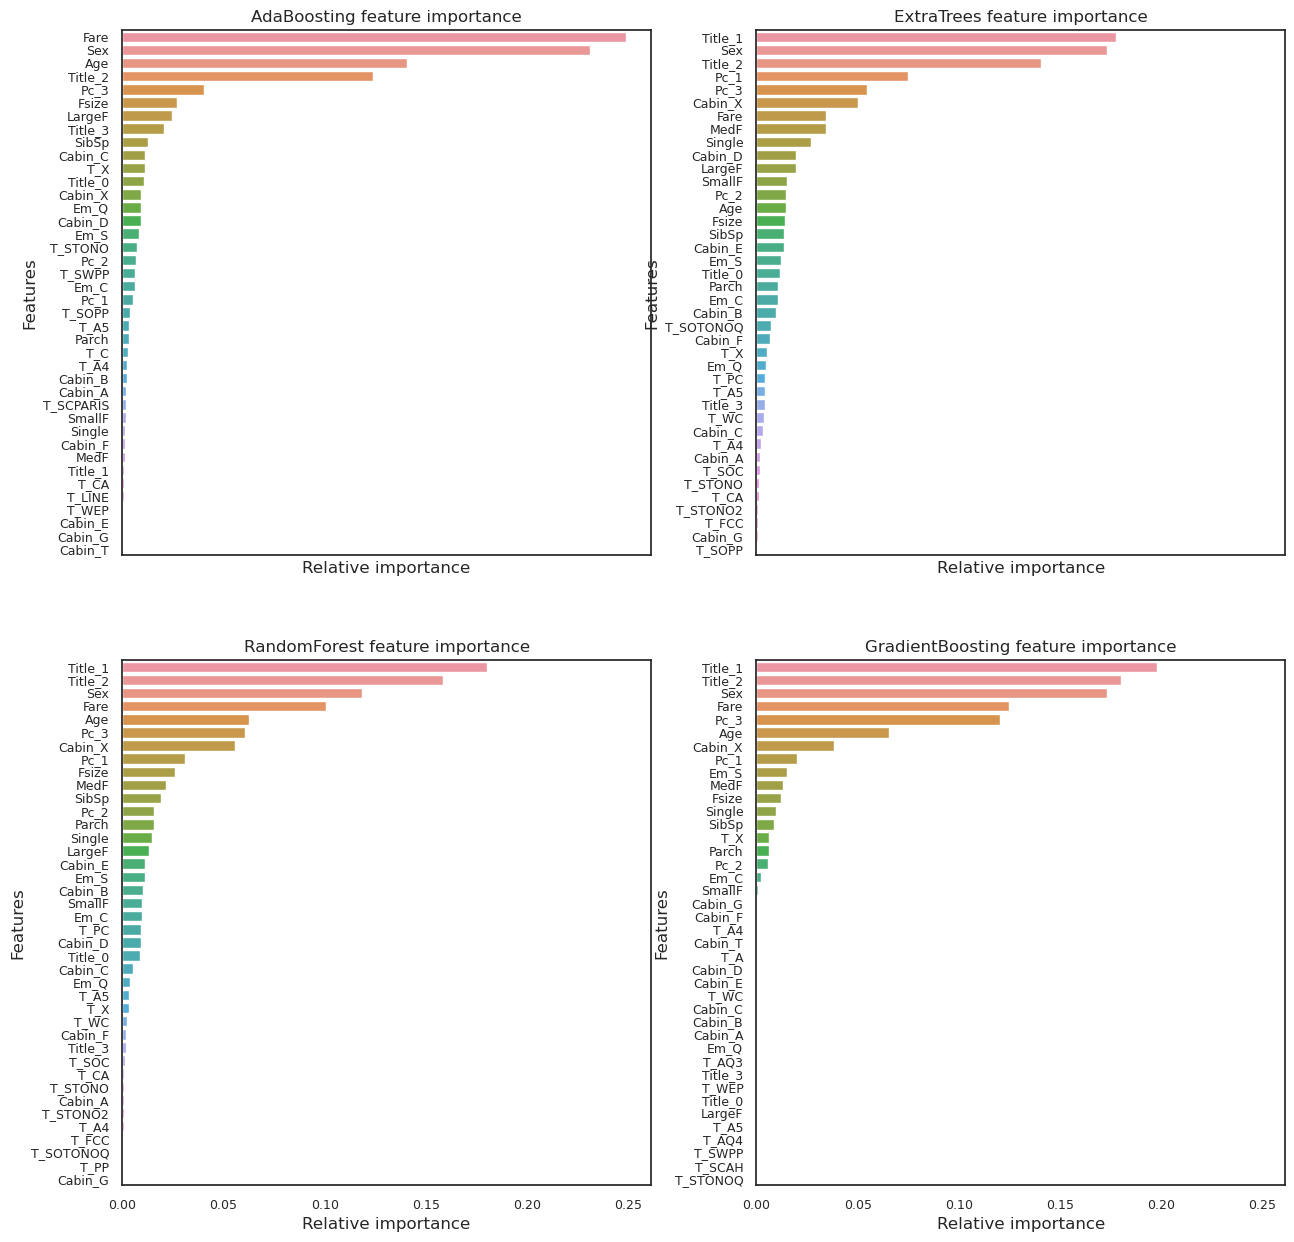

In [84]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

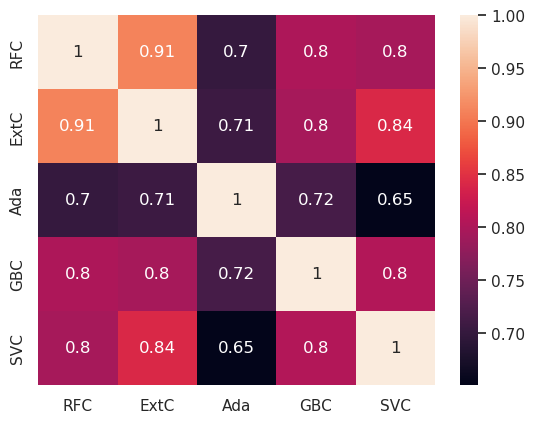

In [85]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

## ensenble modeling
### combining models

In [86]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


## prediciton
### predict and submit results

In [88]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("submit.csv",index=False)